In [63]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [64]:
%matplotlib inline
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [65]:
input_location = 'KTH-alloc-only'
files_prefix = ''

In [66]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-alloc-only/backfill-1_schedule.csv', '../output/KTH-alloc-only/balance-largest-1_schedule.csv', '../output/KTH-alloc-only/balance-ratio-1_schedule.csv', '../output/KTH-alloc-only/balance-smallest-1_schedule.csv', '../output/KTH-alloc-only/fcfs_schedule.csv', '../output/KTH-alloc-only/filler_schedule.csv', '../output/KTH-alloc-only/no-reserve-1_schedule.csv']
['../output/KTH-alloc-only/backfill-1_jobs.csv', '../output/KTH-alloc-only/balance-largest-1_jobs.csv', '../output/KTH-alloc-only/balance-ratio-1_jobs.csv', '../output/KTH-alloc-only/balance-smallest-1_jobs.csv', '../output/KTH-alloc-only/fcfs_jobs.csv', '../output/KTH-alloc-only/filler_jobs.csv', '../output/KTH-alloc-only/no-reserve-1_jobs.csv']


In [67]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    print(workload_name, schedule_name)
    df = pd.read_csv(file)
    df['schedule'] = schedule_name
    df = df.set_index('schedule')
    metrics = metrics.append(df)

 backfill-1
 balance-largest-1
 balance-ratio-1
 balance-smallest-1
 fcfs
 filler
 no-reserve-1


In [68]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    print(workload_name, schedule_name)
    jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 balance-largest-1
 balance-ratio-1
 balance-smallest-1
 fcfs
 filler
 no-reserve-1


In [69]:
schedule_names = ['filler', 'balance-largest-1', 'balance-ratio-1', 'balance-smallest-1', 'backfill-1', 'no-reserve-1', 'fcfs']
metrics.index.rename(None, inplace=True)
metrics = metrics.reindex(schedule_names)

In [70]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'allocated_resources']].apply(lambda row: row.execution_time * len(row.allocated_resources), axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(jobsets, metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [71]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [72]:
metrics.T

,filler,balance-largest-1,balance-ratio-1,balance-smallest-1,backfill-1,no-reserve-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0
makespan,2.88366e+07,2.8783e+07,2.87845e+07,2.8792e+07,2.87804e+07,3.49771e+07,3.81246e+07
max_slowdown,165776,230563,271889,117451,202891,1.65383e+06,9.26291e+06
max_turnaround_time,4.73398e+06,842584,708917,870028,645295,2.74739e+07,9.50694e+06
max_waiting_time,4.7199e+06,842461,694809,869905,581791,2.74738e+07,9.43709e+06
mean_slowdown,241.819,269.501,214.081,221.807,276.146,3151.68,148759
mean_turnaround_time,29072.5,24266.7,23780.1,24803.1,23782.2,544187,5.66148e+06
mean_waiting_time,20219.3,15413.4,14926.9,15949.9,14929,535333,5.65263e+06
nb_computing_machines,109,109,109,109,109,109,109


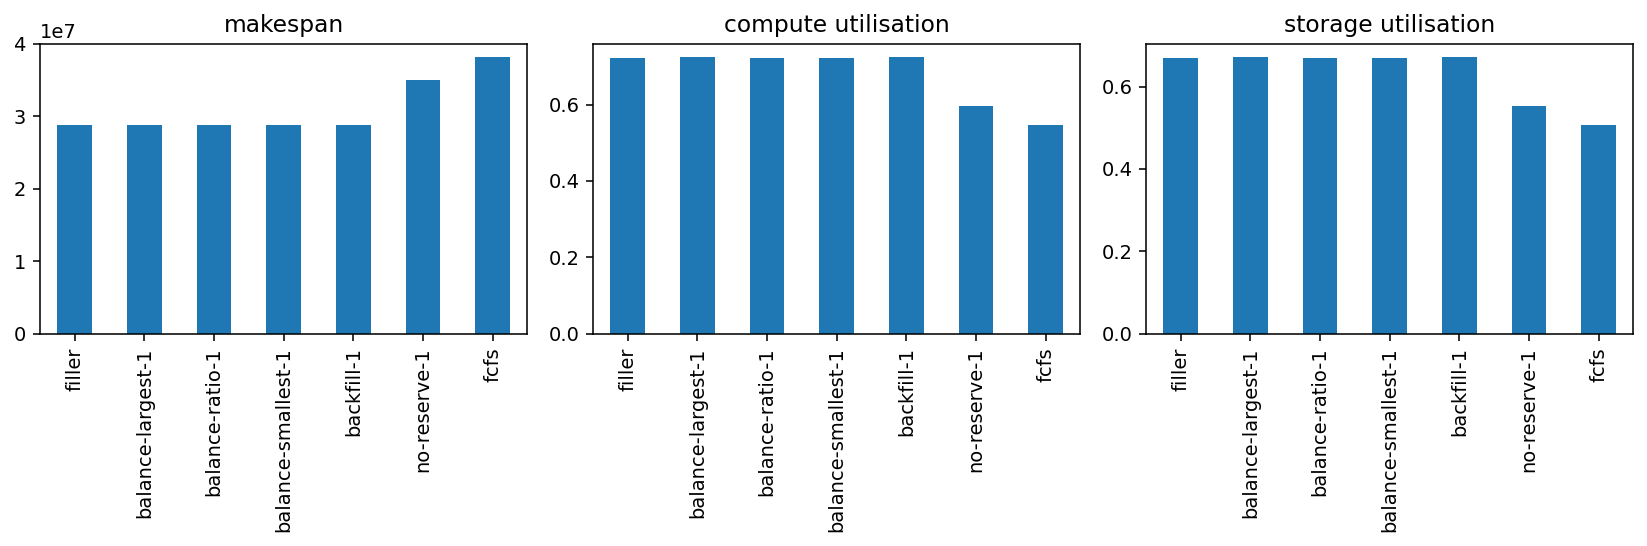

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=140)
metrics['makespan'].plot.bar(title='makespan', ax=axes[0])
metrics['compute_utilisation'].plot.bar(title='compute utilisation', ax=axes[1])
metrics['storage_utilisation'].plot.bar(title='storage utilisation', ax=axes[2])
fig.tight_layout()

<AxesSubplot:>

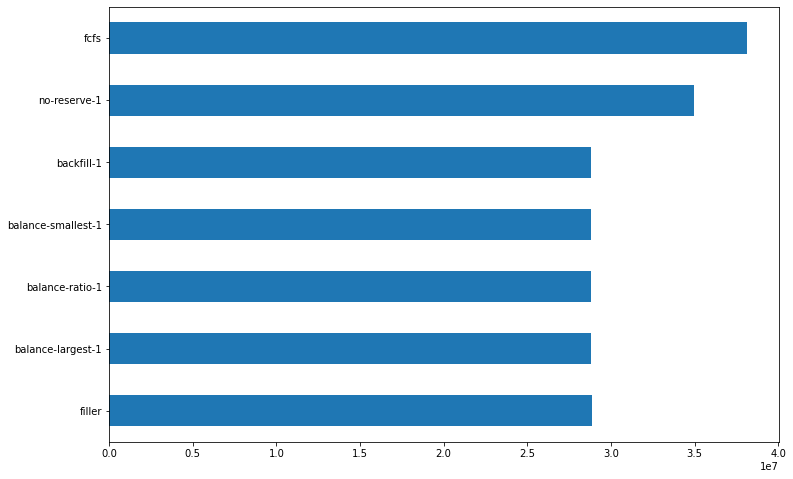

In [76]:
metrics['makespan'].plot.barh(figsize=(12, 8))

<AxesSubplot:>

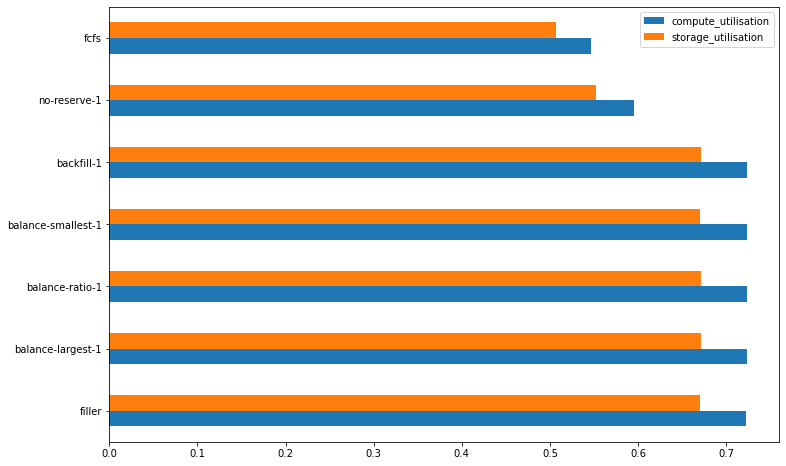

In [75]:
metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(12, 8))

In [46]:
metrics['makespan'].index

Index(['balance-largest-1', 'balance-ratio-1', 'balance-smallest-1',
       'backfill-1', 'no-reserve-1'],
      dtype='object', name='schedule')

In [160]:
waiting_times = create_metric_df(jobsets, 'waiting_time')

<AxesSubplot:>

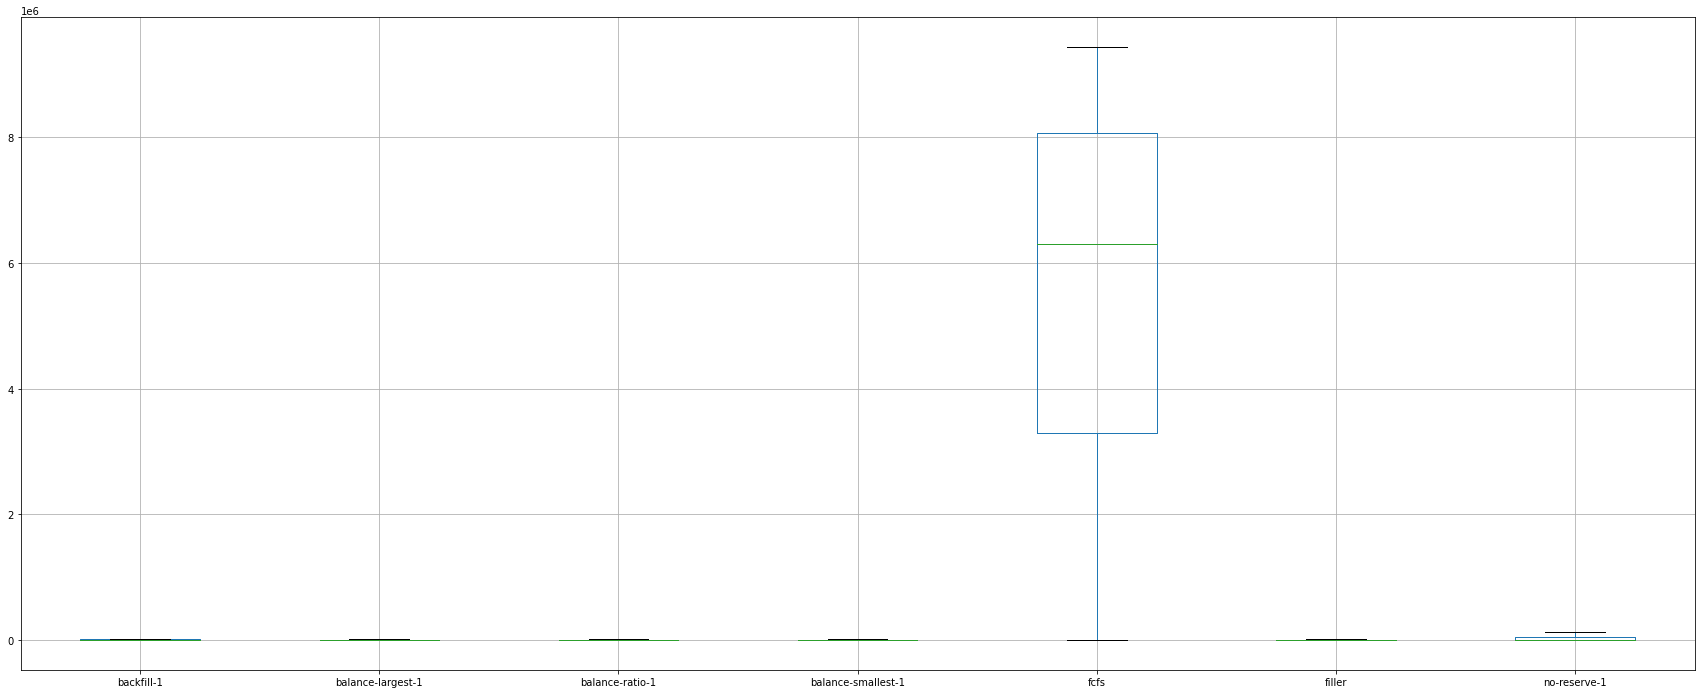

In [161]:
waiting_times.boxplot(showfliers=False, figsize=(30,12))

<AxesSubplot:>

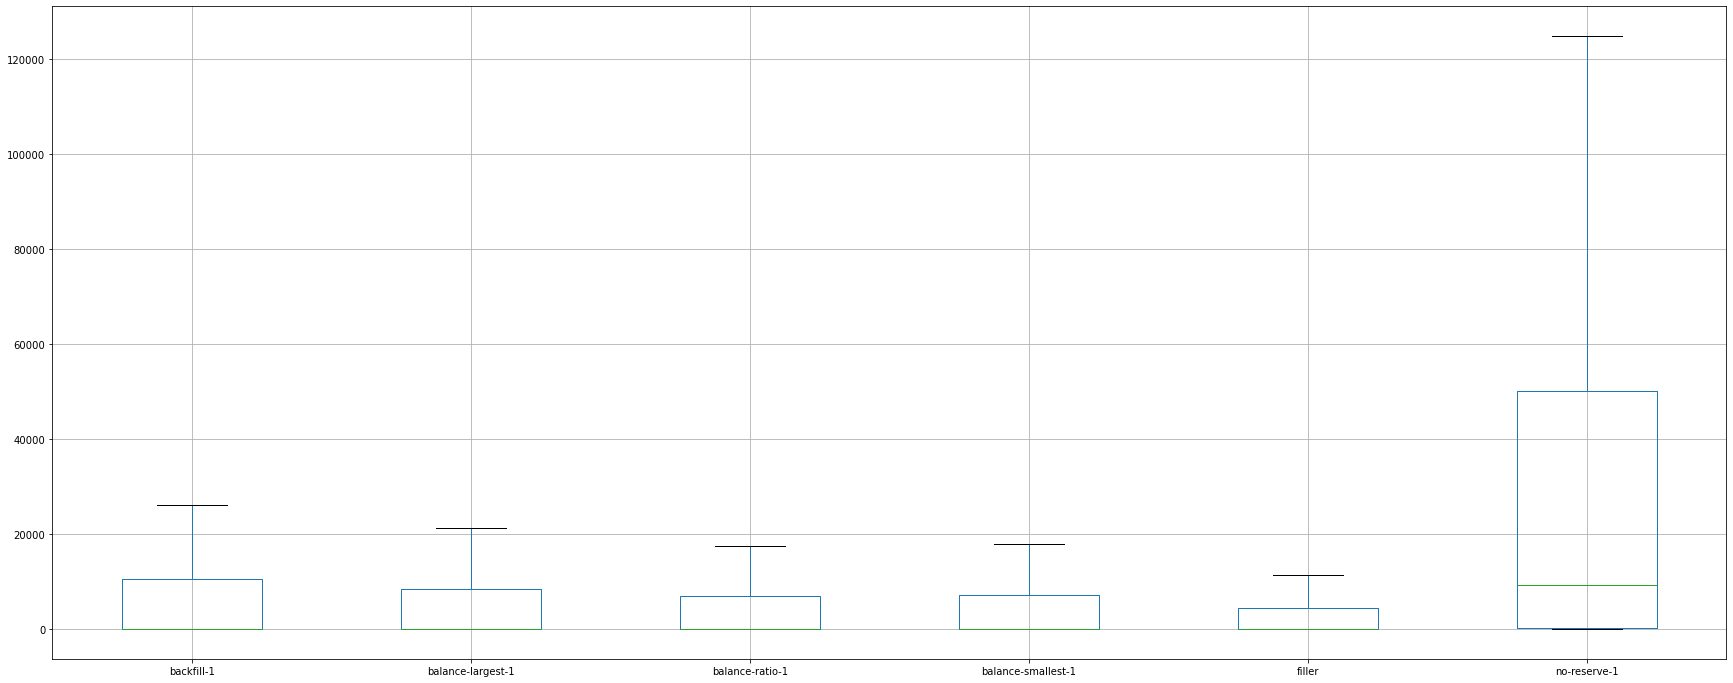

In [162]:
waiting_times.drop('fcfs', axis=1).boxplot(showfliers=False, figsize=(30,12))

In [163]:
turnaround_times = create_metric_df(jobsets, 'turnaround_time')

<AxesSubplot:>

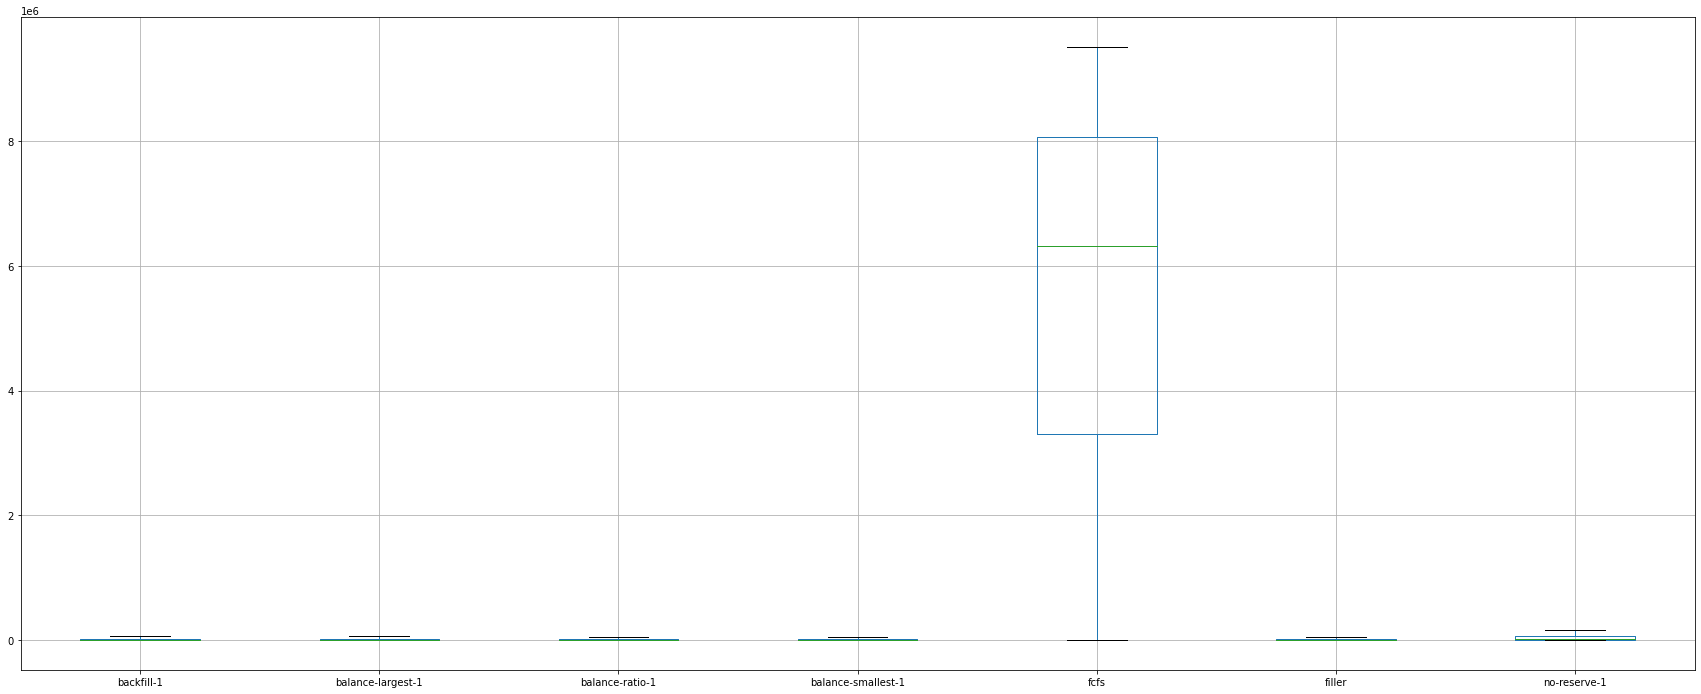

In [164]:
turnaround_times.boxplot(showfliers=False, figsize=(30,12))

<AxesSubplot:>

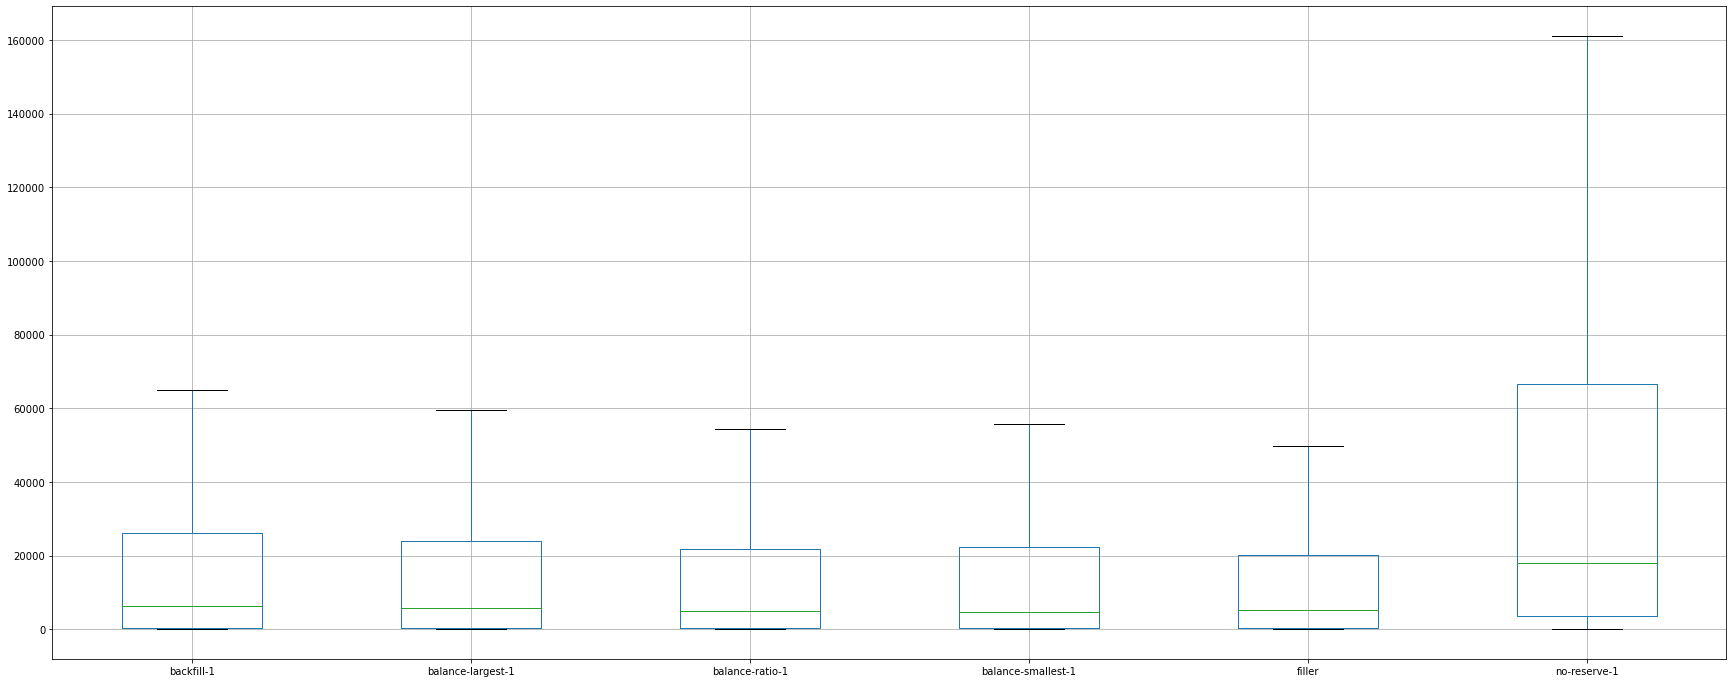

In [165]:
turnaround_times.drop('fcfs', axis=1).boxplot(showfliers=False, figsize=(30,12))

In [166]:
slowdown = create_metric_df(jobsets, 'stretch')

<AxesSubplot:>

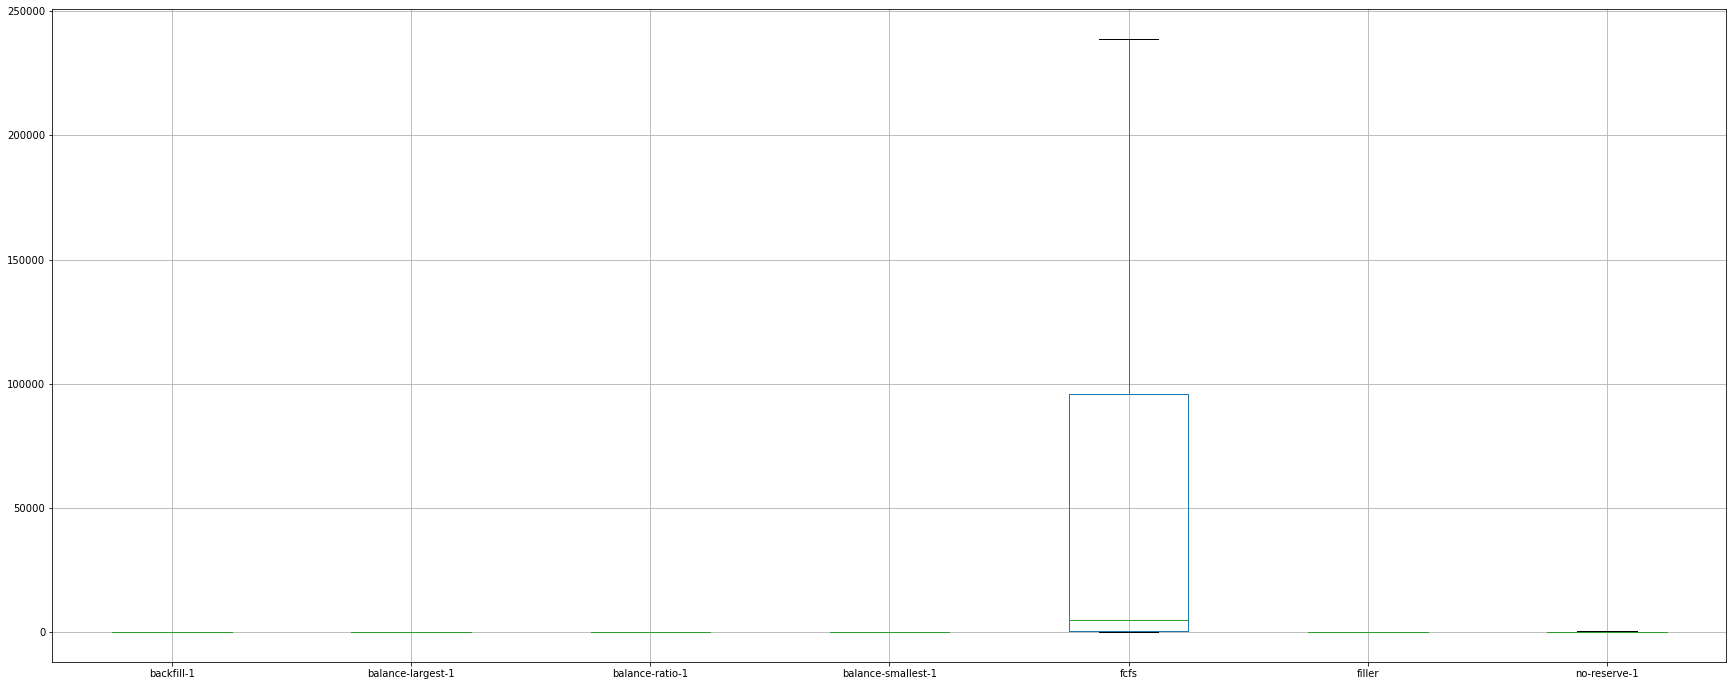

In [167]:
slowdown.boxplot(showfliers=False, figsize=(30,12))

<AxesSubplot:>

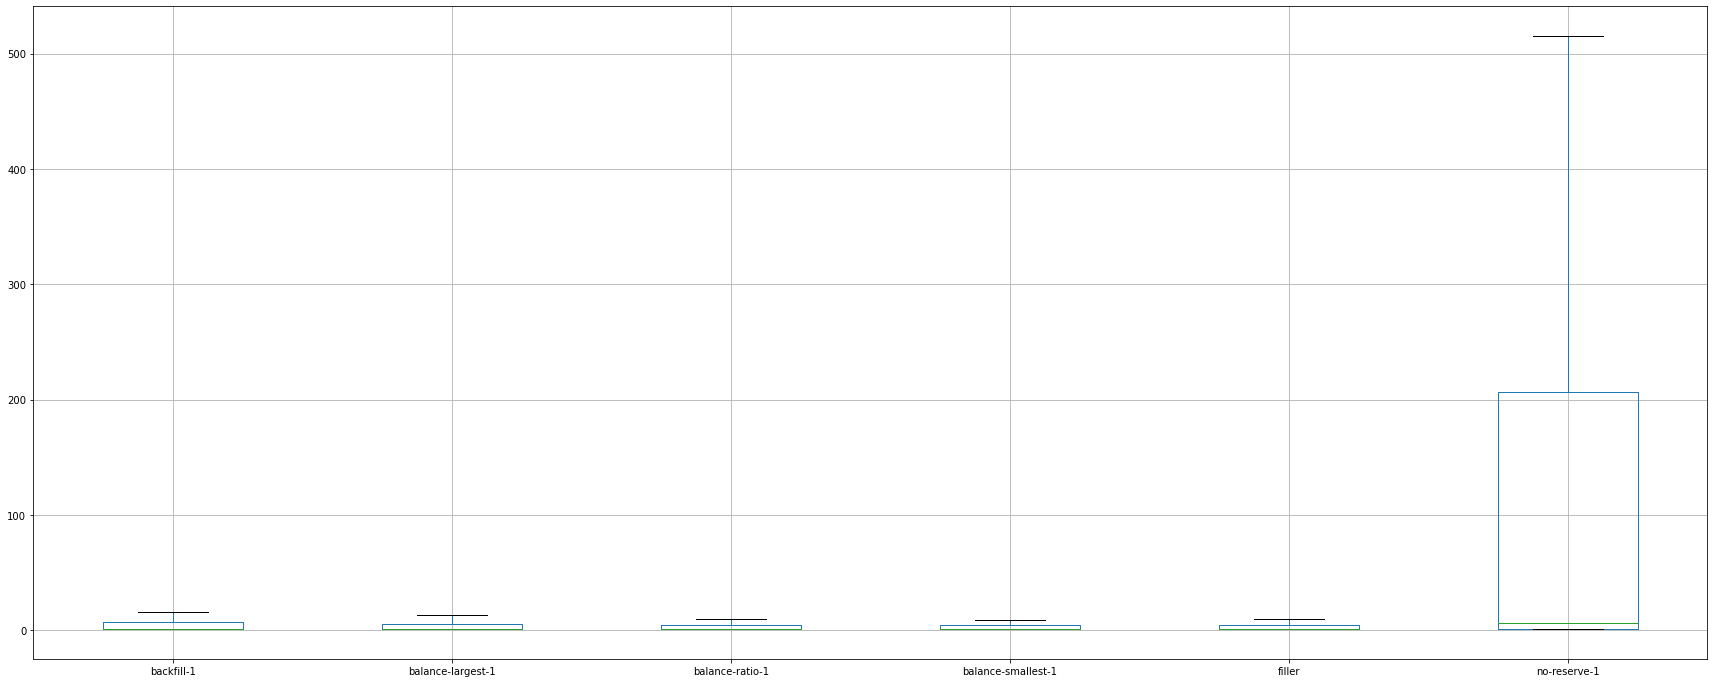

In [168]:
slowdown.drop('fcfs', axis=1).boxplot(showfliers=False, figsize=(30,12))

In [173]:
df = jobsets['balance-ratio-1'].df

In [152]:
visu.plot_series(jobsets['fcfs'], name='execution_time')

TypeError: plot_series() missing 1 required keyword-only argument: 'legend_label'

0.6708115958112205